In [25]:
#!pip3 install numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pprint
pp = pprint.PrettyPrinter(indent=4)
from datetime import datetime
from datetime import timedelta
import RPi.GPIO as GPIO
import time
import progressbar
import inspect, re
#import signal


%matplotlib inline  

In [26]:

#assign pin numbers
msd501pm10pin=5
msd501pm25pin=6
nova10pin=23
nova25pin=24




In [27]:
##############config system#############


def setupGPIO(pin,mode): #mode is either in or out
    GPIO.setmode(GPIO.BCM)
    if mode=="in": 
        GPIO.setup(pin, GPIO.IN)
    else:
        GPIO.setup(pin, GPIO.OUT)

        
        
###### data processing######################
def varname(p):
  for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
    m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
    if m:
      return m.group(1)



def checkarray(pulseinfonova): #### check the generated array
    print(pulseinfonova['pulsewidth10'])
    print(pulseinfonova['pulsewidth25'],"\n\n")
    pp.pprint(pulseinfonova)
    
#generate dataframe
def generatedf(pulseinfonova):
    df=pd.DataFrame({'time':pulseinfonova['time'],
                  'pulsewidth10':pulseinfonova['pulsewidth10'],
                  'pulsewidth25':pulseinfonova['pulsewidth25'],
                  'dust10(ng)':pulseinfonova['pulsewidth10']-2000,
                  'dust10(ug)':(pulseinfonova['pulsewidth10']-2000)/1000,
                  'dust25(ng)':pulseinfonova['pulsewidth25']-2000,
                  'dust25(ug)':(pulseinfonova['pulsewidth25']-2000)/1000,  
                  "time(s)":pulseinfonova['second']/1000,
                  "readtime(s)":pulseinfonova['readtime']})
    #add info
    df["dust10(ppm)"]=df['dust10(ug)']*1.225
    df["dust25(ppm)"]=df['dust25(ug)']*1.225
    df["rolling mean 10(ppm)"] = df["dust10(ppm)"].rolling(10,center=True).mean()
    df["rolling mean 25(ppm)"] = df["dust25(ppm)"].rolling(10,center=True).mean()
    df.fillna(method='bfill',inplace=True)
    df["error10"]= np.power(np.power(df["rolling mean 10(ppm)"]-df["dust10(ppm)"],2),0.4)
    df["error25"]= np.power(np.power(df["rolling mean 25(ppm)"]-df["dust25(ppm)"],2),0.4)
    #fill in na just in case
    df.fillna(method='bfill',inplace=True)
    df.fillna(method='ffill',inplace=True)
    return df


############ reading the pins#######        


def readpulse(pin):   ###read high pulse width
    for i in range(2):
        start = datetime.now()
        stop = datetime.now()
        while GPIO.input(pin) == 0:
            continue
        start = datetime.now()
        while GPIO.input(pin) == 1:
            continue
        stop = datetime.now()
        Elapsed = stop - start
    return Elapsed.total_seconds()*1000000


def readpulsewidth(pin10,pin25,number_of_readings): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time)*1000)
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second}


def read_pulsewidth_and_pulse_time(number_of_readings,pin10=None,pin25=None,pinmsd10=None,pinmsd25=None): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    pulsetime10=np.array([])
    pulsetime25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    readtime_per_channel=np.array([])
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            startreadtime=datetime.now()
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time_for_pulseread=(datetime.now()-startreadtime).total_seconds()*0.25
                readtime_per_channel=np.append(readtime_per_channel,time_for_pulseread)
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time).total_seconds()*1000)
                if pinmsd10:
                    pulsetime10=np.append(pulsetime10,check_low_pulse_for(pinmsd10,time_for_pulseread)["ratio"])                   
                if pinmsd25:
                    pulsetime25=np.append(pulsetime25,check_low_pulse_for(pinmsd25,time_for_pulseread)["ratio"])
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second,"pulsetime10":pulsetime10,"pulsetime25":pulsetime25,"readtime":readtime_per_channel}



def readpulselow(pin): ## read low pulse width
    for i in range(1):
        start = datetime.now()
        stop = datetime.now()
        while GPIO.input(pin) == 1:
            continue
        start = datetime.now()
        while GPIO.input(pin) == 0:
            continue
        stop = datetime.now()
        Elapsed = stop - start
    return Elapsed.total_seconds()*1000



def check_low_pulse_for(pin,period):#period in seconds #check low ratio in active low circuits over a period #return dict
    start=datetime.now()
    #signal.alarm(period)
    activeperiod=0
    while (datetime.now()-start).total_seconds()<period:
        activeperiod+=readpulselow(pin)
    
    totalperiod=(datetime.now()-start).total_seconds()*1000
    #print ("Timeout! at {time_elasped}".format(time_elasped=(datetime.now()-start).total_seconds()))
    return {'lowpulse':activeperiod,'total_period':totalperiod,'ratio':activeperiod/totalperiod}
    

    
def readlowsensorasdf(pin,size,period):###output dataframe from readings with specified repitition and period return df
    readings=[]
    output_dict={}
    for i in range(size):
        readings.append(check_low_pulse_for(msd501pm10pin,period))
    for i in readings[0].keys():
        output_dict[i]=[]
    for i in readings:
        for j in i.keys():
            output_dict[j].append(i[j])
    return pd.DataFrame(output_dict)    
    

####### debug functions#####


def infinite_loop():
    start=datetime.now()
    try:
        while True:
            print('the time is {time}'.format(time=(start-datetime.now()).total_seconds()))
            time.sleep(1)
    
    except Exception:
        print ("Timeout! at {time_elasped}".format(time_elasped=(datetime.now()-start).total_seconds()))
        
        
def testpulse(pin,periods):
    #end_time = datetime.now() + timedelta(seconds=20)
    count=0
    while count<periods:
        #time.sleep(1)
        #print(GPIO.input(23))
        dustlevel= float(readpulse(pin)+1-1)-2
        print("the dust level is :", dustlevel)
        count+=1

def testlowpulse(pin,times=5):
    for i in times:
        Lowpulse = readpulselow(pin)
        print(Lowpulse)

In [28]:
#set up gpio
pin_input=[msd501pm10pin, msd501pm25pin, nova10pin,nova25pin]
pin_name=['msd501pm10pin', 'msd501pm25pin', 'nova10pin','nova25pin']
for pin in pin_input:
    setupGPIO(pin,"in")

In [33]:
#run test for output
for pin,name in zip(pin_input,pin_name):
    print(name)
    testpulse(pin,5)

msd501pm10pin
the dust level is : 53945.0
the dust level is : 14224.0
the dust level is : 14634.0
the dust level is : 16629.0
the dust level is : 12885.0
msd501pm25pin
the dust level is : 8610.0
the dust level is : 8632.0
the dust level is : 8630.0
the dust level is : 8586.0
the dust level is : 8586.0
nova10pin
the dust level is : 10985.0
the dust level is : 10984.0
the dust level is : 10983.0
the dust level is : 11981.0
the dust level is : 10985.0
nova25pin
the dust level is : 11982.0
the dust level is : 11984.0
the dust level is : 11982.0
the dust level is : 11979.0
the dust level is : 11983.0


In [12]:
#set data variables
datasize=10

#call data
#pulseinfonova=readpulsewidth(nova10pin,nova25pin,datasize)
pulseinfonova=read_pulsewidth_and_pulse_time(datasize,nova10pin,nova25pin,msd501pm10pin,msd501pm25pin)
checkarray(pulseinfonova)


100% (10 of 10) |########################| Elapsed Time: 0:00:36 Time:  0:00:36


[18956. 18963. 18962. 18961. 18961. 18964. 18967. 18967. 18959. 18968.]
[19963. 20954. 20952. 20961. 20961. 20963. 20964. 20958. 20961. 20964.] 


{   'pulsetime10': array([0.58630699, 0.58195401, 0.58305895, 0.58675718, 0.58484184,
       0.57490461, 0.58804159, 0.58785127, 0.57586581, 0.58790644]),
    'pulsetime25': array([0.53391448, 0.5425144 , 0.54489895, 0.54319938, 0.53849972,
       0.55651338, 0.53968797, 0.53992246, 0.55815522, 0.54319371]),
    'pulsewidth10': array([18956., 18963., 18962., 18961., 18961., 18964., 18967., 18967.,
       18959., 18968.]),
    'pulsewidth25': array([19963., 20954., 20952., 20961., 20961., 20963., 20964., 20958.,
       20961., 20964.]),
    'readtime': array([0.68511   , 0.65524075, 0.66927925, 0.66083025, 0.66248275,
       0.66672875, 0.66549375, 0.664791  , 0.66636625, 0.66526675]),
    'second': array([ 2741.556,  6751.033, 10759.516, 14768.292, 18777.234, 22785.939,
       26794.863, 30803.964, 34812.868, 38822.028]),
    'time': [   '20

In [18]:
df=generatedf(pulseinfonova)
df.head(5)

,dust10(ng),dust10(ug),dust25(ng),dust25(ug),pulsewidth10,pulsewidth25,readtime(s),time,time(s),dust10(ppm),dust25(ppm),rolling mean 10(ppm),rolling mean 25(ppm),error10,error25
0,16956.0,16.956,17963.0,17.963,18956.0,19963.0,0.685110,2019-02-04 02:20:24,2.741556,20.771100,22.004675,20.77943,23.103623,0.021703,1.078404
1,16963.0,16.963,18954.0,18.954,18963.0,20954.0,0.655241,2019-02-04 02:20:28,6.751033,20.779675,23.218650,20.77943,23.103623,0.001292,0.177272
2,16962.0,16.962,18952.0,18.952,18962.0,20952.0,0.669279,2019-02-04 02:20:32,10.759516,20.778450,23.216200,20.77943,23.103623,0.003917,0.174245
3,16961.0,16.961,18961.0,18.961,18961.0,20961.0,0.660830,2019-02-04 02:20:36,14.768292,20.777225,23.227225,20.77943,23.103623,0.007494,0.187768
4,16961.0,16.961,18961.0,18.961,18961.0,20961.0,0.662483,2019-02-04 02:20:40,18.777234,20.777225,23.227225,20.77943,23.103623,0.007494,0.187768


In [20]:
#save file
filename="./data/test{time}_{samples}samples.csv".format(time=datetime.now().strftime("%d%b%y_%H:%M"),samples=datasize)
df.to_csv(filename)

In [23]:
#load file
filename='./data/test04Feb19_03:53_10samples.csv'
df=pd.read_csv(filename)

In [24]:
df.head()

,Unnamed: 0,dust10(ng),dust10(ug),dust25(ng),dust25(ug),pulsewidth10,pulsewidth25,readtime(s),time,time(s),dust10(ppm),dust25(ppm),rolling mean 10(ppm),rolling mean 25(ppm),error10,error25
0,0,14967.0,14.967,16965.0,16.965,16967.0,18965.0,0.748534,2019-02-04 03:53:12,3.008074,18.334575,20.782125,17.84531,19.68036,0.564463,1.080615
1,1,14967.0,14.967,16966.0,16.966,16967.0,18966.0,0.624155,2019-02-04 03:53:16,7.016833,18.334575,20.783350,17.84531,19.68036,0.564463,1.081577
2,2,14974.0,14.974,15967.0,15.967,16974.0,17967.0,0.686997,2019-02-04 03:53:20,11.024661,18.343150,19.559575,17.84531,19.68036,0.572363,0.184336
3,3,14966.0,14.966,15966.0,15.966,16966.0,17966.0,0.657528,2019-02-04 03:53:24,15.033302,18.333350,19.558350,17.84531,19.68036,0.563332,0.185830
4,4,14966.0,14.966,15968.0,15.968,16966.0,17968.0,0.670351,2019-02-04 03:53:28,19.042050,18.333350,19.560800,17.84531,19.68036,0.563332,0.182839


In [137]:
def plotchart(df):
    #create charts to show the distribution of the readings
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 10))
    sns.set(style="darkgrid")
    #Plot against dust (line)
    sns.relplot(x="time(s)", y="dust10(ppm)",kind="line",data=df,ax=ax1)
    sns.relplot(x="time(s)", y="rolling mean 10(ppm)",kind="line",color="coral",data=df,ax=ax1)
    sns.lineplot(x="time(s)", y="rolling mean 10(ppm)",color="coral",data=df,ax=ax2)
    ax2.errorbar(df["time(s)"],y=df["rolling mean 10(ppm)"],yerr=df["error10"],color="c")
    ax1.set_title("moving average vs raw data")
    return[ax1,ax2]

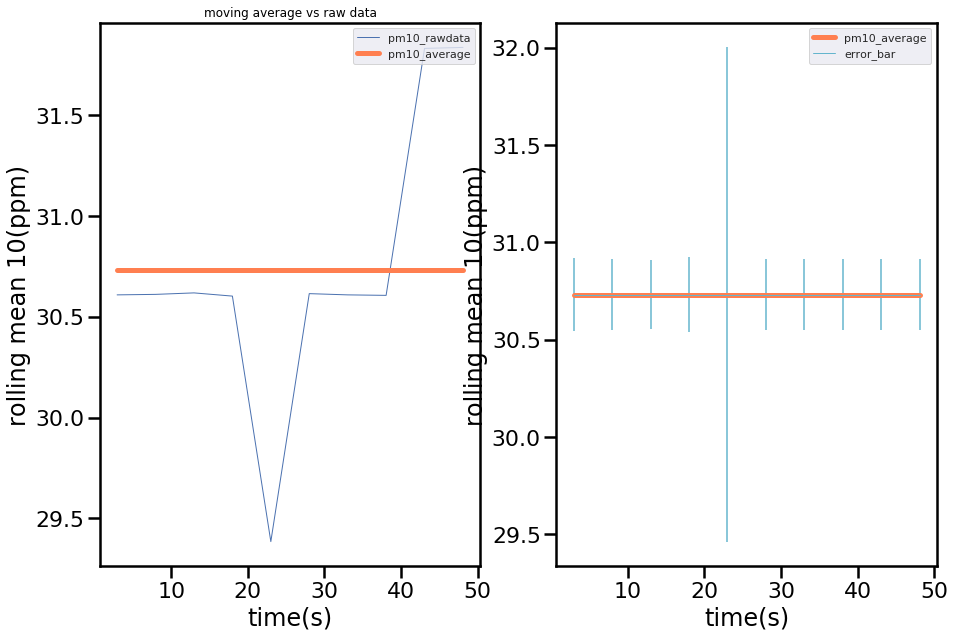

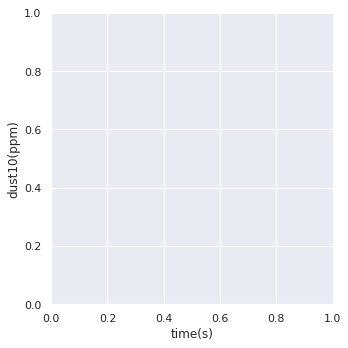

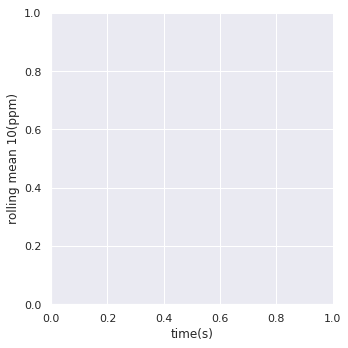

In [138]:
ax1,ax2=plotchart(df)
#ax1.lines[0].get_linewidth()
plt.setp(ax1.lines[0],linewidth=1)
plt.setp(ax1.lines[1],linewidth=5)
plt.setp(ax2.lines[0],linewidth=5)
plt.setp(ax2.lines[1],linewidth=1)
ax1.legend(handles=ax1.lines, labels=["pm10_rawdata","pm10_average"],loc='upper right')
ax2.legend(handles=ax2.lines, labels=["pm10_average","error_bar"],loc='upper right')

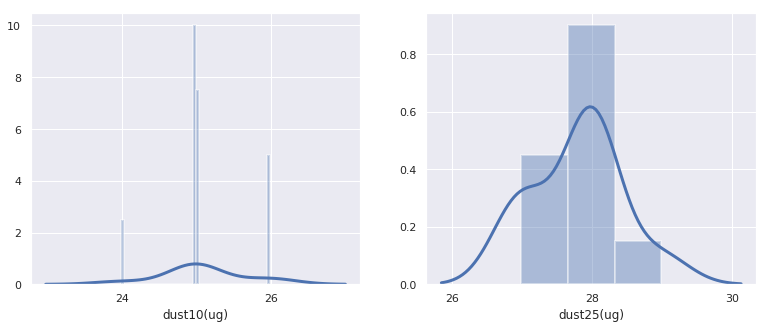

In [139]:
f, axes = plt.subplots(1, 2,figsize=(13, 5))
sns.set_context("poster")
sns.distplot(df["dust10(ug)"],ax=axes[0])
sns.distplot(df["dust25(ug)"],ax=axes[1])

# READ dm501

In [45]:
msd501pm10_reading=check_low_pulse_for(msd501pm10pin,2)
print(msd501pm10_reading)

{'ratio': 0.5875662179808938, 'total_period': 2000.212, 'lowpulse': 1175.2569999999996}


In [75]:
pprint.pprint(readings)  

[{'lowpulse': 1173.841999999999,
  'ratio': 0.5868722895999626,
  'total_period': 2000.1660000000002},
 {'lowpulse': 1175.1959999999988,
  'ratio': 0.5875589273313319,
  'total_period': 2000.133},
 {'lowpulse': 1175.6359999999988,
  'ratio': 0.5877777372249995,
  'total_period': 2000.137},
 {'lowpulse': 1180.7599999999998,
  'ratio': 0.5903428084030705,
  'total_period': 2000.1259999999997},
 {'lowpulse': 1178.1299999999985,
  'ratio': 0.5890261242757971,
  'total_period': 2000.1319999999998},
 {'lowpulse': 1183.9279999999997,
  'ratio': 0.5919261167285291,
  'total_period': 2000.1280000000002},
 {'lowpulse': 1181.0960000000005,
  'ratio': 0.5905107978197377,
  'total_period': 2000.1259999999997},
 {'lowpulse': 1186.303000000001,
  'ratio': 0.593112354584598,
  'total_period': 2000.1319999999998},
 {'lowpulse': 1184.2010000000007,
  'ratio': 0.5920620159689624,
  'total_period': 2000.1299999999999},
 {'lowpulse': 1184.540999999999,
  'ratio': 0.5922337815055462,
  'total_period': 2000.

In [82]:

readings_df=readlowsensorasdf(msd501pm10pin,10000,0.1)
readings_df.describe()

,lowpulse,ratio,total_period
count,10000.000000,10000.000000,10000.000000
mean,65.506176,0.600163,109.048443
std,5.883107,0.035426,5.649903
min,58.848000,0.544536,100.020000
25%,60.055000,0.558190,107.784000
50%,60.768500,0.601161,107.929000
75%,71.868000,0.639889,112.090000
max,73.510000,0.653215,120.102000


In [85]:
readings_df.to_csv("./data/readings_df{datetime}.csv".format(datetime=datetime.now().strftime("%d%b%y_%H:%M")))

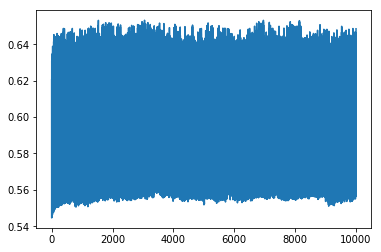

In [83]:
ax=plt.plot(readings_df['ratio'])

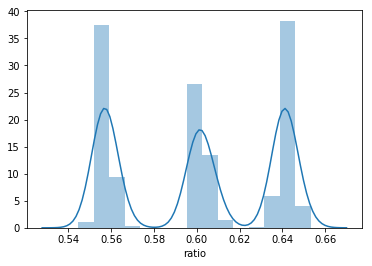

In [86]:
sns.distplot(readings_df['ratio']);

In [123]:
def read_pulsewidth_and_pulse_time(number_of_readings,pin10=None,pin25=None,pinmsd10=None,pinmsd25=None): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    pulsetime10=np.array([])
    pulsetime25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            startreadtime=datetime.now()
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1 and pulsereading25 > 1:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time_for_pulseread=(datetime.now()-startreadtime).total_seconds()*0.5
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time).total_seconds()*1000)
                if pinmsd10:
                    pulsetime10=np.append(pulsetime10,check_low_pulse_for(pinmsd10,time_for_pulseread)["ratio"])                   
                if pinmsd25:
                    pulsetime25=np.append(pulsetime25,check_low_pulse_for(pinmsd25,time_for_pulseread)["ratio"])
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second,"pulsetime10":pulsetime10,"pulsetime25":pulsetime25}

In [124]:
read_pulsewidth_and_pulse_time(5,nova10pin,nova25pin,msd501pm10pin,msd501pm25pin)


pin10 is read 27.985
pin25 is read 30.979
1.0368665
pulse10 is read


N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

pulse25 is read
pin10 is read 27.976
pin25 is read 30.973
1.457234
pulse10 is read


 40% (2 of 5) |##########                | Elapsed Time: 0:00:05 ETA:   0:00:08

pulse25 is read
pin10 is read 27.979
pin25 is read 30.979
1.037069
pulse10 is read


 60% (3 of 5) |###############           | Elapsed Time: 0:00:10 ETA:   0:00:08

pulse25 is read
pin10 is read 27.982
pin25 is read 30.98
1.468241
pulse10 is read


 80% (4 of 5) |####################      | Elapsed Time: 0:00:15 ETA:   0:00:05

pulse25 is read
pin10 is read 27.976999999999997
pin25 is read 30.979
1.0272225
pulse10 is read


100% (5 of 5) |##########################| Elapsed Time: 0:00:20 Time:  0:00:20


pulse25 is read


{'pulsetime10': array([0.58634406, 0.59170871, 0.59095303, 0.59372239, 0.59400292]),
 'pulsetime25': array([0.55996166, 0.55496657, 0.55676298, 0.55742841, 0.55734262]),
 'pulsewidth10': array([27.985, 27.976, 27.979, 27.982, 27.977]),
 'pulsewidth25': array([30.979, 30.973, 30.979, 30.98 , 30.979]),
 'second': array([ 2074.719,  7091.951, 12109.061, 17126.548, 22143.94 ]),
 'time': ['2019-02-02 14:00:41',
  '2019-02-02 14:00:46',
  '2019-02-02 14:00:51',
  '2019-02-02 14:00:56',
  '2019-02-02 14:01:01']}